# Demo for Property Inference Attack (PIA)

In [21]:
from privacy_evaluator.attacks.property_inference_attack import PropertyInferenceAttack
from privacy_evaluator.classifiers.classifier import Classifier
from privacy_evaluator.utils.data_utils import (
    dataset_downloader,
    new_dataset_from_size_dict,
)
from privacy_evaluator.utils.trainer import trainer
from privacy_evaluator.models.torch.cnn import ConvNet

import collections
from matplotlib import pyplot as plt

## Property Inference Attack on CIFAR10 Dataset
### 1. Overview of Dataset

In [20]:
train_dataset, test_dataset = dataset_downloader("CIFAR10")
input_shape = test_dataset[0][0].shape
print(input_shape)

(32, 32, 3)


<ipython-input-34-cf0213d3db51>:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_images_to_display / columns + 1, columns, i + 1)


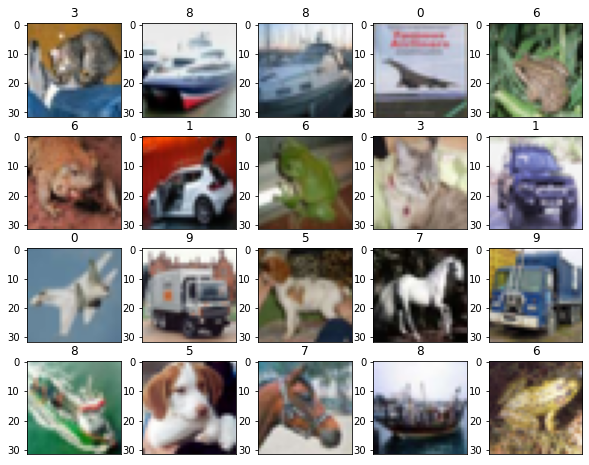

In [34]:
plt.figure(figsize=(10, 10))
num_images_to_display, num_columns = 20, 5
for i, image in enumerate(test_dataset[0][:num_images_to_display]):
    plt.subplot(num_images_to_display / num_columns + 1, num_columns, i + 1)
    plt.imshow(image)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.set_title(str(int(test_dataset[1][i])))

The class distribution for both training set and test set is presented below. We notice that CIFAR10 has strictly balanced representation over all 10 classes, both in training and test set.

In [16]:
print(sorted(collections.Counter(train_dataset[1].flatten()).items()))
print(sorted(collections.Counter(test_dataset[1].flatten()).items()))

[(0, 5000), (1, 5000), (2, 5000), (3, 5000), (4, 5000), (5, 5000), (6, 5000), (7, 5000), (8, 5000), (9, 5000)]
[(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


### 2. Organization of Training Data for Image Classifiers
To similify our study, here we only take two classes (`O: airplane` and `1: automobile`) from both the training- and test-dataset of CIFAR10.

In this part we would like to clarify how we prepare training set(s) for our image classifiers:

#### For Target Model  
tbc
#### For Shadow Classifiers 
tbc

In [ ]:
num_elements_per_classes = {0: 1000, 1: 1000}
num_classes = len(num_elements_per_classes)
train_set = new_dataset_from_size_dict(train_dataset, num_elements_per_classes)

### 3. Model Architechture of Image Classifiers

The target model and all the shadow classifiers share 

In [ ]:
model = ConvNet(num_classes, input_shape)
trainer(train_set, num_elements_per_classes, model)
# convert to art classifier
target_model = Classifier._to_art_classifier(model, num_classes, input_shape)

### 4. Meta Classifier
#### 4.1. Architechture

#### 4.2. Input (Extracted Features)
Here the each input instance is a flattened vector (**feature vector**) of all the trainable parameters from the corresponding image classifier. 
For example, the feature vector of our target model is

In [ ]:
# length of the feature vector of the target model
print(extracted_features_target_model.shape)

### 5. Results and Visualization

## Property Inference Attack on MNIST Dataset
### 1. Overview of Dataset

In [18]:
train_dataset, test_dataset = dataset_downloader("MNIST")
input_shape = test_dataset[0][0].shape
print(input_shape)

(28, 28)


In [19]:
print(sorted(collections.Counter(train_dataset[1].flatten()).items()))
print(sorted(collections.Counter(test_dataset[1].flatten()).items()))

[(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)]
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


### 2. Image Classfiers
As to the model architechture, we use the same as in CIFAR10 scenario. The only difference lies in the in

### 3. Meta Classifier
Here we apply the same meta classifier above.

### 4. Results and Visualization